In [1]:
import numpy as np
from matplotlib import pyplot as plt
import simple_GP_temperature.helper_sklearn as helper
from simple_GP_temperature.bell_curve import Bellcurve
from simple_GP_temperature.non_convex_function import NonConvexFunction
from simple_GP_temperature.random_initial_2d import RandomInit2D
from simple_GP_temperature.BO_GP_temperature import BOTemperatureGP
from simple_GP_temperature.fullfactor_initial import FullFactorInitial2D
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
objective = NonConvexFunction()

In [3]:
initial_sample_lst = [[6.20,6.20],[6.25,6.20],[6.30,6.20],[6.20,6.25],[6.25,6.25],[6.30,6.25],[6.20,6.30],[6.25,6.30],[6.30,6.30]]

In [4]:
initial_method = FullFactorInitial2D(fullfactorinput_list=initial_sample_lst)

In [5]:
bayes_opt_fullfactor = BOTemperatureGP(evaluation_component=objective, initial_method=initial_method, initial_sample_size= 8, lower_bound=[-10,-10], upper_bound=[10,10], total_iter=50)

In [ ]:
bayes_opt_fullfactor.optimise()

In [6]:
fullfactor_mappings_lst=[]
for i in tqdm(range(30)):
    fullfactor_mappings_lst.append(bayes_opt_fullfactor.optimise())

  0%|                                                    | 0/30 [00:35<?, ?it/s]


KeyboardInterrupt: 

In [10]:
FD_opt_mappings_lst=[]
for i in tqdm(range(30)):
    FD_opt_mappings_lst.append(bayes_opt_fd.optimise(training_samples= trainingsample, evaluation_scores= evaluation_score))

100%|███████████████████████████████████████████| 30/30 [02:43<00:00,  5.46s/it]


In [11]:
threshold = 0.1
converge_iter_num_lst = []
for FD_opt_mappings in FD_opt_mappings_lst:
    converge_iter_num_lst.append(find_stable_point(FD_opt_mappings, start_index = 9, threshold = 0.1))

In [12]:

none_replacement = max([x for x in converge_iter_num_lst if x is not None]) * 2 
replaced_list = [x if x is not None else none_replacement for x in converge_iter_num_lst]

In [13]:
converge_iter_num_lst

[None,
 10,
 56,
 118,
 145,
 170,
 202,
 102,
 249,
 19,
 21,
 24,
 24,
 25,
 27,
 29,
 32,
 34,
 36,
 33,
 35,
 37,
 37,
 40,
 41,
 43,
 44,
 46,
 48,
 74]

In [16]:
for mapping in FD_opt_mappings_lst:
    print (len(mapping))

109
159
209
259
309
359
409
459
509
559
609
659
709
759
809
859
909
959
1009
1059
1109
1159
1209
1259
1309
1359
1409
1459
1509
1559


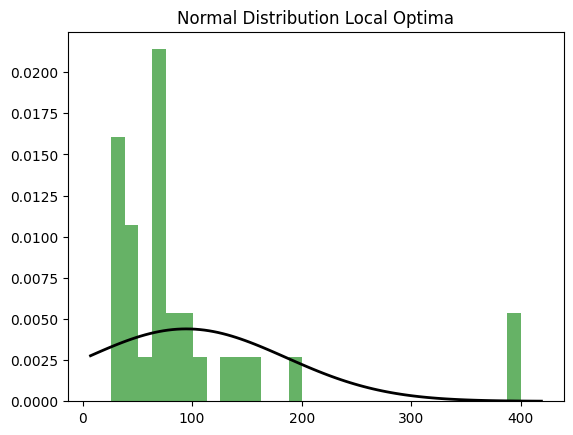

In [18]:
import seaborn as sns
import numpy as np
from scipy.stats import norm
numbers = replaced_list
plt.hist(numbers, bins=30, density=True, alpha=0.6, color='g')
 # Create a normal distribution line
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-np.power((x - np.mean(numbers)), 2) / (2 * np.std(numbers) ** 2)) / (np.sqrt(2 * np.pi) * np.std(numbers))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Normal Distribution Local Optima")
plt.show()